In [1]:
## BEGIN
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{ "size":16}) #**{,,'serif':['Palatino']
rc('text', usetex=True)
import numpy.random as rnd
rnd.seed()
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import pickle as cp
import scipy.optimize as opt
from scipy.optimize import curve_fit as fit
#import mps
import cProfile
import subprocess
from scipy.special import hyp2f1, erf
from scipy.optimize import brentq

import itertools

In [2]:

def percolate(field, h):
    pos =  field <= h # sign cluster
    mask = np.where((pos).reshape(-1))[0]
    #print(len(mask))
    active_graph = full_graph[mask,:]
    active_graph = active_graph[:, mask]
    n_components, labels = sp.csgraph.connected_components(active_graph, directed=0, return_labels=1)
    #topset = set(labels[mask < L])
    
    return len(set(labels[mask < L]).intersection(labels[mask > (L**2-L)])) 

def gethc(field, precision = 1e-2, **kwargs ):
    lo, hi = np.min(field), np.max(field)
    while hi - lo > precision:
        mi = (hi + lo)/2
        if percolate(field, mi):
            hi = mi
        else:
            lo = mi
    return (hi + lo)/2

def frac_laplacian(L,ratio = 1, H = 0., **kwargs): 
    L1 = int(L * ratio)
    ps = np.sin(np.arange(L) / L * np.pi) * L
    qs = np.sin(np.arange(L1) / L1 * np.pi) * L1
    
    ps, qs = np.meshgrid(ps, qs)
    laplacian = (ps ** 2 + qs ** 2) 
    laplacian[0,0] = 1
    laplacian **= (-H/2 - 1/2)
    laplacian[0,0] = 0. 
    mini = np.sum(laplacian[::2, ::2] + laplacian[1::2, 1::2] 
                  - laplacian[1::2, ::2] - laplacian[::2, 1::2])
    #laplacian[0,0] = -mini 
    return laplacian
def get_var(L, H = 0):
    laplacian = frac_laplacian(L, H)
    return np.sum(laplacian ** 2)
def prepare_graph(L, ratio = 1, cut_boundary = 1, bond_perco = 1, **kwargs):
    xy2i = lambda x,y:x*L + y
    L1 = int(L * ratio) 
    xs, ys =  np.arange(L* L1) // L, np.arange(L* L1) % L
    eps = (xs + ys) % 2 * 2 - 1
    xp, xm = (xs + 1) % L1, (xs - 1) % L1
    yp, ym = (ys + 1) % L, (ys - 1) % L
    # this is bond percolation on the square lattice
    connec = 6 if bond_perco else 4
    if bond_perco:
        inds = np.hstack((
            xy2i(xp, ys), xy2i(xm, ys), 
            xy2i(xs , yp), xy2i(xs , ym), 
            xy2i(xp, (ys + eps) % L), xy2i(xm,  (ys - eps) % L), 
            )).reshape(connec, -1).T.reshape(-1)
    else:
        inds = np.hstack((
            xy2i(xp, ys), xy2i(xm, ys), 
            xy2i(xs , yp), xy2i(xs , ym)
            )).reshape(connec, -1).T.reshape(-1)
    data = np.ones_like(inds, dtype=int)
    indptr = np.arange(L * L1 + 1) * connec
    full_graph = sp.csc_matrix((data, inds, indptr),shape=(L*L1, L*L1))
   # print(len(full_graph.data))
    # remove the edges of one periodic boundary
    if cut_boundary:
        lil = full_graph.tolil()
        lil[:L, -L:] = 0
        lil[-L:, :L] = 0
        if cut_boundary > 1:
            # in this case cut both periodicity
            lil[::L, L-1::L] = 0
            lil[L-1::L, ::L] = 0
        full_graph = lil.tocsc()
    return full_graph

# Percolation transition

We study numerically the bond percolation on a square lattice. Every bond is activated with probability $p$. A percolation transition takes place at a threshold $p_c$: in the infinite system limit, there exists an "infinite cluster" (*cluser* means connected component in percolation jargon) with probability $1$ if $p > p_c$, and with probability $0$ if $p < p_c$. 

The value of $p_c$ depends on the microscopic details and is not universal. For the bond percolation on the square lattice, one can show by a duality argument that $p_c = 1/2$. 

## Nice pictures first

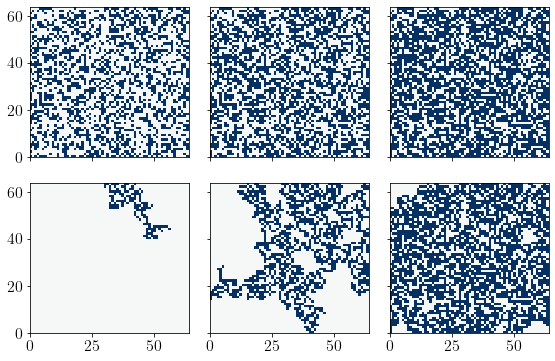

In [33]:
L = 64
full_graph = prepare_graph(L, bond_perco=1, cut_boundary = 2)
field = rnd.rand(L,L)
fig, ax = plt.subplots(2,3, figsize = (8,5.3), sharex="all", sharey="all")
for k,p in enumerate( [.4, .5, .6]):
    
    pos = field <= p
    mask = np.where((pos).reshape(-1))[0]
    #print(len(mask))
    active_graph = full_graph[mask,:]
    active_graph = active_graph[:, mask]
    n_components, labels = sp.csgraph.connected_components(active_graph, directed=0, return_labels=1)
    plt.sca(ax[0, k])
    plt.pcolor(pos.reshape(L,L), cmap='RdBu', vmax=1, vmin=-1)
    #plt.yticks([])
    #plt.xticks([])
    plt.sca(ax[1, k])
    
    h, b = np.histogram(labels, bins = np.arange(n_components+1)-.5)
    max_ind = np.argmax(h)
    
    max_comp = np.zeros(L**2)
    max_comp[mask[labels==max_ind]] = 1
    
    plt.pcolor((max_comp).reshape(L, L), cmap="RdBu",  vmax=1, vmin=-1)
    #plt.yticks([])
    #plt.xticks([])
plt.tight_layout()

For $p=0.4, 0.5, 0.6$ (left, middle, right), we plot the activated bonds (top row) and the largest cluster (bottom row). 

## Infinite cluster: finite size scaling

The probability of having an infinite cluster has a sharp jump only in the thermodynamic limit. 
For finite systems, we need to first define what an infinite cluster means. One way is to consider a square lattice with open boundary condition, and ask whether the top and the bottom are connected. If so, we say there is an infinite cluster

With this definition, one can measure the existence probability of an infinite cluster as a function of $p$ (and as always, of the system size $L$),

### $$P_\infty(p) := \text{existence probability of infinite cluster at $p$ }$$

Then we will perform a critical scaling. 

*The method used below is a standard trick among numericists, but is not that important for our purposes. Basically, instead of flipping a coin for each bond, we order the bonds randomly, and activate them one by one. Then at some (random) threshold fraction $q$ of activated bonds, an infinite cluster will appear. It is not hard to convince oneself that*
#### $$\mathrm{Prob}(q < p) = \mathbb{P}_{\infty}(p)$$

In [16]:
res_hc = dict()

In [17]:

for L in [16, 32, 64]:
    full_graph = prepare_graph(L, bond_perco=1, cut_boundary = 2)
    for rep in range(500):
        #if H == -1:
        field = rnd.rand(L,L)
        if (L) not in res_hc:
            res_hc[L] = []
        hc = gethc(field)
        p = np.mean(field < hc)
        res_hc[L].append(p)
        if rep % 100 == 0:  
            print(".", end="")

...............

Text(0, 0.5, '$P_{\\infty}(p)$')

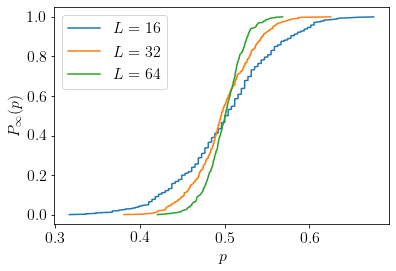

In [24]:
for (L), pcs in res_hc.items():

    if len(pcs) > 0:
        
        plt.plot( (np.sort(pcs) ) ,  
                   np.linspace(0, 1,len( pcs)), label = "$L = %d$" % L) # / norm ** .5
plt.legend()
plt.xlabel(r"$p$")
plt.ylabel(r"$P_{\infty}(p)$")

Text(0, 0.5, '$P_{\\infty}(p)$')

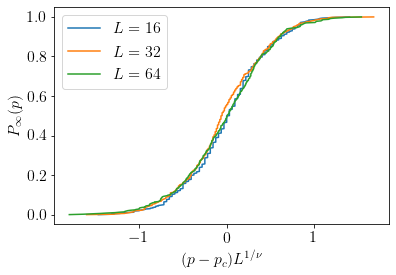

In [26]:
for (L), pcs in res_hc.items():

    if len(hcs) > 0:
        
        plt.plot( (np.sort(pcs) - .5) * L ** (3/4) ,  
                   np.linspace(0, 1,len( pcs)), label = "$L = %d$" % L) # / norm ** .5
plt.legend()
plt.xlabel(r"$(p - p_c) L^{1/\nu}$")
plt.ylabel(r"$P_{\infty}(p)$")

The finite size scaling confirmed the correlation length exponent 
$$\nu = 4/3$$
for the 2D percolation transition. (This is an exact result, but requires a good deal of conformal field theory to understand.)

## One point function 

From the illustration above, it is tempting to consider the size of the largest cluster, $S_{\max}$ as a probe of the transition: when $p> p_c$, we expect $S_{\max} / L^2$ to tend to a constant, or in other words, a nonzero portion $m$ of points belong to a same cluster. This portion is the analogue of the spontaneous magnetization in the Ising model (in the ferromagnetic phase). As in the Ising model, its critical scaling involves another independent exponent: 
### $$ \Delta_{\sigma} = 5/48 $$
Again, this is a nontrivial prediction of conformal field theory.

Below we test this prediction by measureing $m$ near the critical point, on the percolating side.

In [140]:
hs = np.linspace(.5, .6, 13)
Ls = 2 ** np.arange(4, 7)
res_sizes = dict()


In [141]:

for L in Ls:
    ######################################
    #construct the graph
    full_graph = prepare_graph(L, bond_perco=1, cut_boundary=0)


    for rep in range(500):
        field = rnd.rand(L,L)

        for h in hs:
            pos =  field <= h
            mask = np.where((pos).reshape(-1))[0]
   
            active_graph = full_graph[mask,:]
            active_graph = active_graph[:, mask]
            n_components, labels = sp.csgraph.connected_components(active_graph, directed=0, return_labels=1)
           
            his, b = np.histogram(labels, bins = np.arange(n_components+1)-.5)
            ans = np.max(his) / L ** 2

            if (L,h) not in res_sizes:
                res_sizes[L,h] = [ans]
            else:
                res_sizes[L,h].append(ans)

        if rep % 100 == 0: print('.', end="")

...............

Text(0, 0.5, '$m$')

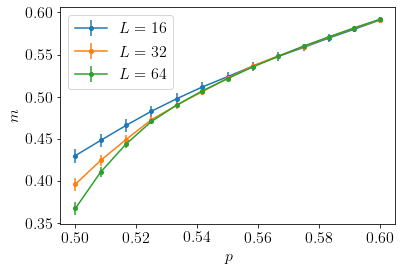

In [146]:

for L in Ls:
    Hs = []
    Ms = []
    Es = []
    for h in hs:
        if (L,h) in res_sizes:
            data = res_sizes[L,h]
            Ms.append(np.mean(data))
            Es.append(np.std(data) / len(data) ** .5 * 2)
            Hs.append(h )
    if len(Hs):
        Hs = np.array(Hs)
        plt.errorbar(Hs , Ms, yerr=Es, marker="o", linestyle="-", label="$L=%d$" % L, markersize=4)
plt.legend()    
plt.xlabel(r"$p$")
plt.ylabel(r"$m$")

Text(0, 0.5, '$m L^{\\Delta_{\\sigma}}$')

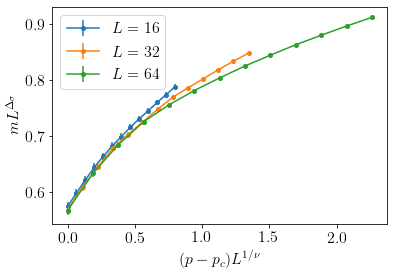

In [150]:

for L in Ls:
    Hs = []
    Ms = []
    Es = []
    for h in hs:
        if (L,h) in res_sizes:
            data = res_sizes[L,h]
            Ms.append(np.mean(data))
            Es.append(np.std(data) / len(data) ** .5 * 2)
            Hs.append(h )
    if len(Hs):
        Hs = np.array(Hs)
        plt.errorbar((Hs - 1/2) * L ** (3/4) , np.array(Ms) * L ** (5/48), yerr=Es, marker="o", linestyle="-", label="$L=%d$" % L, markersize=4)
plt.legend()    
plt.xlabel(r"$(p - p_c) L^{1/\nu}$")
plt.ylabel(r"$m L^{\Delta_{\sigma}}$")
#plt.yscale("log")

### Make an argument for the following hyperscaling relation
### $$ m_{L\to\infty} \sim |p-p_c|^{\nu \Delta_{\sigma}}$$

- Back-of-the-envelope "dimensional analysis": $m \sim L^{-\Delta_\sigma}$, $L \sim |p-p_c|^{-\nu}$

- Slightly more savant: start from single variable scaling $m  = L^{-\Delta_\sigma} f((p-p_c) L^{1/v}) $, and consider the limit $L \to \infty$.



## Two point function

Recall in Ising that another way to probe the $\Delta_\sigma$ exponent is to consider the spin-spin correlation function. In percolation, we consider the probability that two points are in a same cluster (connectivity). Why? This has to do with the Kasterleyn Fortuin representation, which smoothly interpolates between Ising ($Q=2$ Potts) and percolation ($Q \to 1$ Potts, believe it or not).

In [171]:
res_2p = dict()

In [174]:

for nL in range(4, 8):
    print(nL)
    L = 2 ** nL
    full_graph = prepare_graph(L, bond_perco=1, cut_boundary=0)
    #print(len(full_graph.data))
    ##
    if L in res_2p:
        rs, ans = res_2p[L]
    else:
        rs = 2 ** np.arange(nL)
        ans = np.zeros(len(rs) + 1, dtype=float)
        res_2p[L] = (rs,ans)
    for rep in range(100):
        print(".", end="")
        field = rnd.rand(L,L) * 2 - 1
        pos =  field <= 0 
        mask = np.where((pos).reshape(-1))[0]
        #print(len(mask))
        active_graph = full_graph[mask,:]
        active_graph = active_graph[:, mask]
        n_components, labels = sp.csgraph.connected_components(active_graph, directed=0, return_labels=1)
        label_real = -np.ones(L ** 2, dtype=int) 
        label_real[mask] = labels 
        label_real = label_real.reshape(L, -1)
        for j,x in enumerate(rs):
            intersect = (label_real ==  np.roll(label_real, x, axis = 1)) * (label_real >= 0)    
            ans[j+1] += (np.sum(intersect) / L ** 2)
        ans[0] += 1
    
   # plt.plot( (ans[1:] / ans[0]) ** -2, "o-")

4
....................................................................................................5
....................................................................................................6
....................................................................................................7
....................................................................................................

Text(0, 0.5, '$P_2(r)$')

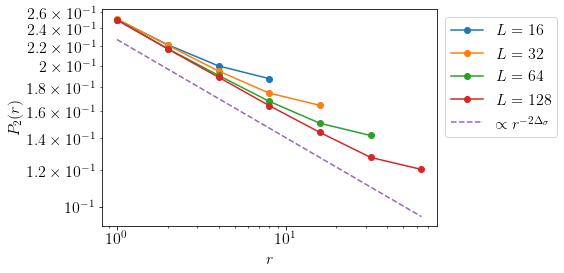

In [178]:
for L, (rs, ans) in res_2p.items():
    plt.loglog(rs, ans[1:] / ans[0], "o-", label="$L=%d$" % L)
plt.plot(rs, rs ** (-5/24) * ans[1] / ans[0] / 1.1, "--", label = "$\propto r^{-2\Delta_{\sigma}}$")
plt.legend(bbox_to_anchor = (1,1))
plt.xlabel("$r$")
plt.ylabel("$P_2(r)$")